In [1]:
### BEGIN hide_toggle
### Update 30/10-'20
def hide_toggle_code(off=0):
    """This function generates HTML code to toggle the display of an input
    cell.
    
    The output of the cell will still be displayed.  This can be used
    to hide (from immediate view) some code to generate data or the
    like.  It can also be used to hide other notebook explicit
    implementations - e.g., C++ processing, or the like.
    
    Note, calling this function alone will not enable toggling.
    Instead, we must wrap the generated code in an
    `IPython.display.HTML` object and return that as the cell value.
    This will let IPython evaluate the HTML code and pass it on to the
    browser.
    
    If all one wants is to toggle a cell one can use the function
    `hide_toggle` below.  However, we can also combine the code
    generated here with other HTML code - for example _style_
    declarations and pass that along embedded in an HTML object.
    
    Parameters
    ----------
    off : int 
        Offset of cell to hide relative to the cell calling this function 
    
    Returns
    -------
    code : str 
        HTML code to enable toggling of the cell

    """
    from random import randint 
    from IPython.display import HTML 
    
    jp_cell     = 'document.getElementsByClassName("jp-Cell jp-mod-selected")[0]'
    jq_cell     = '$("div.cell.code_cell.rendered.selected")'
    toggle_text = 'Please close'
    cell_id     = str(randint(1,2**64))
    func_name   = f'code_toggle_{cell_id}'
    
    scr1 = f'''
    <script id="s{cell_id}">
      function {func_name}() {{
          if (typeof $ == "undefined") {{
              // console.log("For JupyterLab (no jQuery)")
              var c  = {jp_cell};
              // console.log(c);
              var iw = c.getElementsByClassName("jp-Cell-inputArea")[0];
              var op = c.getElementsByClassName("jp-OutputPrompt")[0];
              // console.log(iw,op)
              if (iw.style.display !== undefined && iw.style.display === "none") {{
                  iw.style.display = null;
                  op.style.display = null;
              }} else {{
                  iw.style.display = "none";
                  op.style.display = "none";
              }}
           }}
           else {{
                console.log('Will toggle input display {jp_cell}')
                console.log({jp_cell})
                {jq_cell}.find("div.input").toggle();
                {jq_cell}.find("div.out_prompt_overlay.prompt").toggle();
                {jq_cell}.find("div.out_prompt_overlay.prompt").toggle();
                {jq_cell}.find("div.prompt.output_prompt").toggle();
                console.log('End toggle input display {jp_cell}')
           }}
      }}  
    </script>
    '''
    but = f'''
     <details style='z-index:99;position:relative;color:lightgray;' 
             onclick='javascript:{func_name}()'>
        <summary>&gt;</summary>
    </details>
    '''
    scr2 = f'''
    <script>
      var c = null;
      if (typeof $ == "undefined") {{
         var c  = document.getElementById("s{cell_id}");
         var p  = c.parentNode.parentNode.parentNode.parentNode.parentNode;
         var iw = p.getElementsByClassName("jp-Cell-inputArea")[0];
         var op = p.getElementsByClassName("jp-OutputPrompt")[0];
         var ou = c.parentNode;
         iw.style.display = "none";
         op.style.display = "none";
         ou.style.background = "transparent";
      }}
      else {{
          var p = $('#s{cell_id}').parents();
          p.siblings('div.input').hide();
          p.find('div.prompt.output_prompt').hide()
          p.find('div.out_prompt_overlay.prompt').hide()      
      }}
      // {func_name}
    </script>
    '''
    return scr1+but+scr2        

def hide_toggle(off=0,cnt=None):
    """This will wrap the HTML code returned from the above function
    in an `IPython.display.HTML` object so that the notebook will 
    evaluate the HTML code. 
    
    This function is what we will use most of the time.  However, 
    the function `hide_toggle_code` can be combined with other code 
    and then be put  into an HTML object to let the notebook evaluate
    all the code. 

    Parameters 
    ----------
    off : int 
        Cell offset relative to calling cell which we should toggle 
    cnt : int or None 
        If not None, set the execution count to this number 
        (currently broken)
        
    Returns
    -------
    object : IPython.display.HTML 
        HTML object wrapping code to toggle cell 
    """
    from IPython.display import HTML
    if cnt is not None:
        get_ipython().execution_count = cnt
    return HTML(hide_toggle_code(off))
### END hide_toggle

### BEGIN patch_execute
### Update 30/10-'20
def patch_execute_code():
    html = '''
    <script>
    if (typeof Jupyter == 'undefined') {
        console.log("Cannot patch CodeCell.execute - probably JupyterLab")
    }
    else {
        if (Jupyter.CodeCell.execute_patched == undefined) {
            console.log('Patching CodeCell.execute')
            
            Jupyter.CodeCell.prototype.old_execute = Jupyter.CodeCell.prototype.execute;
            Jupyter.CodeCell.prototype.execute = function (stop_on_error) {
                if (this.metadata !== undefined && 
                    this.metadata.tags !== undefined) {
                    if (this.metadata.tags.indexOf('no-execution') !== -1 ||
                        this.metadata.tags.indexOf('no-execute')   !== -1
                        ) {
                        console.log('Not executing this code cell');
                        return;
                    }
                };
                console.log('Executing as normal');
                this.old_execute(stop_on_error);
            }
            
            console.log('Patched CodeCell.execute');
            
            Jupyter.CodeCell.execute_patched = true;
        }
        else {
            console.log(Jupyter.CodeCell.execute_patched);
        }
    }
    </script>
    '''
    return html

def patch_execute():
    from IPython.display import HTML 
    return HTML(hide_toggle_code()+patch_execute_code())
### END patch_execute

### BEGIN show_all
def _show_all():
    try:
        from IPython.core.interactiveshell import InteractiveShell
        InteractiveShell.ast_node_interactivity = "all"
    except:
        pass 
### END show_all

### BEGIN setup_matplotlib
### Update 30/10-'20
def _setup_matplotlib():
    """Set-up Matplotlib parameters. 
    
    We specify that we want both PDF and PNG images, and 
    that the default image size should be 8 by 8 inches 
    
    We also disable warnings about too many open figures 
    """
    %matplotlib inline 
    from matplotlib import rcParams 
    
    rcParams['figure.max_open_warning'] = 0
    rcParams['font.serif'] = ['Palatino'] + rcParams['font.serif']
    rcParams['font.family'] = ['serif']
    rcParams['mathtext.fontset'] = 'dejavuserif'
    rcParams['axes.formatter.use_mathtext'] = True

    f = None
    try:
        # IPython >= 7.23 depcrates set_matplotlib_formats
        from matplotlib_inline.backend_inline import set_matplotlib_formats
        f = set_matplotlib_formats
        
    except Exception as e:
        try:
            from IPython.display import set_matplotlib_formats
            f = set_matplotlib_formats
        except Exception as e:
            pass 

    if f is not None:
        set_matplotlib_formats('png','pdf')
        
_setup_matplotlib()
### END setup_matplotlib
_setup_matplotlib()

### BEGIN css_styling
### Update 30/10-'20
def css_styling_code():
    """This function returns HTML code to customize the CSS 
    of the notebook 
    
    - The text font to be Palatino (serif)
    - Headers are oblique (italic)
    - Extra spacing below H1 headers 
    - Extra spacing spacing above H1 headers 
    - Headers have larger fonts, and is set in normal weight
    - Remove padding around code cells 
    - Code uses the fint "Source Code Pro" (or monospace)
    - Code background is changed to light yellow 
    - Output background is set to lavender
    
    The function combines these CSS declarations with the HTML 
    code from `hide_toggle_code` above so what we automatically 
    hide this code from the user. 
    """
    styles = '''
    <style>
    .rendered_html, .jp-RenderedHTMLCommon {
        font-family: Palatino, serif
    }
    h1, h2, h3, h4, .jp-RenderedHTMLCommon h1, .jp-RenderedHTMLCommon h2, .jp-RenderedHTMLCommon h3, .jp-RenderedHTMLCommon h4{
        font-style: oblique;  
    }
    jp-RenderedHTMLCommon h1:first-child {
        margin-top: 4ex;
    }
    .jp-RenderedHTMLCommon h1, .rendered_html h1 {
        margin-bottom: 2ex;
        font-weight: normal;
        font-size: 220%;
    }
    .jp-RenderedHTMLCommon h2, .rendered_html h2 {
        font-weight: normal;
        font-size: 180%;
    }
    .jp-RenderedHTMLCommon h3, .rendered_html h3 {
        font-weight: normal
    }
    .jp-RenderedHTMLCommon h4, .rendered_html h4 {
        font-weight: normal
    }
    p code {
        padding: 0;
    }
    .CodeMirror, .jp-Notebook .CodeMirror.cm-s-jupyter, code, div.input_area {
        font-family: "Source Code Pro", source-code-pro,Consolas, monospace;
        background: lightyellow;
    }
    .output_text, .output_stream, .output_stdout, .jp-OutputArea-executeResult .jp-OutputArea-output {
        background: lavender;
    }
    .output_error {
        background-color: #fff2f2;
    }
    .celltag_alert-info li {
        list-style-image:  url(data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAABAAAAAQCAYAAAAf8/9hAAAAAXNSR0IArs4c6QAAAAZiS0dEAP8A/wD/oL2nkwAAAAlwSFlzAAALEwAACxMBAJqcGAAAAAd0SU1FB9gEGxE4IQYzJ14AAAI3SURBVDjLZZNPSFVBFIe/e9+zd3silBCl0SZoU4s2rVq0EB5tQip4UNvATVGu3QRBiyAi2iltWkgbF5EgRhFFRpiWtrWIzDIV1Pzz7p15M2fmtvDevOqBw8DM9zvnN8ycgF3R/eDtM2mac96ZdrFNxBikqbRV+vHH/ut9gAZczoe7C3gnF0f6au1OLM5avFi8d1Ea+JvAMSAq8nsKOGs5f2cYJ3Y7rc2PO4BqkS8DdD98f9tbe1ysCoxOBo1qlEXHJWcM4b5KPU19zleA0o4Clx99eO3EdqVewHsCoFRugUoVghJO7A6H6Vx9wdtYi27cr5x6dy/03nVtWTU7bWeZh6jNUcAiCaFTURl9A+gs56AviHzh3mnqtdPxm6knfQPLU7UaokASQq/agY7yDrG16Mba6Pz48NP56VdrgAApYObGaicPtkovToFLQBKA/WUxTe3FRk4san15aGKgd3Dj560rrdGJS6FT0X9YYvLuiMKL1kAQOpHZ3PqfyZfP41+9PW1VfzX0RXFSECfgNEmSTgImdDruF2O0E8vvqZG1auQubAsKooIYYHpGvwA2g+xndQBHgWa6cG0ih5cW/w6VvEq3nChwCoBvs+bL2Z7VceBHGTDAIrABpMVuhw+4OiLgLIglOLPYBTQAlfErIeCzjRVg1dtEb1kt5Omv+DTV2YssAN+zNdkzC42N9brV8WdvYp07seOdM2Of1F3AAknW0AJpwN6IgEPAEaANaMlcbmZdl7KRBuAfAb+v//yMAJoAAAAASUVORK5CYII=);
    }
    </style>
    <script>
    if (typeof $ !== "undefined") {
  $(function(){
 $(".celltag_alert         .text_cell_render").addClass("alert");
 $(".celltag_alert-info    .text_cell_render").addClass("alert alert-info");
 $(".celltag_alert-warning .text_cell_render").addClass("alert alert-warning");
 $(".celltag_alert-danger  .text_cell_render").addClass("alert alert-danger");
 $(".celltag_alert-success .text_cell_render").addClass("alert alert-successs");
      });
    }
    </script>
    '''
    return styles

def css_styling():
    from IPython.display import HTML 
    
    return HTML(hide_toggle_code()+css_styling_code())
### END css_styling

def _do_all():
    from IPython.display import HTML
    return HTML(hide_toggle_code()+css_styling_code()+patch_execute_code())

_do_all()

### Christian Holm Christensen <a class='tocSkip'></a>

# Introduction to Jupyter Notebook<a class='tocSkip'></a>
## With Python <a class='tocSkip'></a>
## 0.1 - November 2020 <a class='tocSkip'></a>

> In this note, we will introduce working with Python in a Jupyter Notebook.  We will discuss interacting with the notebook, writing code in _Code_ and text in _Markdown_ cells. 
>
> This document is available in many formats at https://cholmcc.gitlab.io/nbi-python

### Niels Bohr Institutet <a class='tocSkip'></a>

### Christian Holm Christensen <a class='tocSkip'></a>

# Introduktion til Jupyter Notebook<a class='tocSkip'></a>
## Med Python <a class='tocSkip'></a>
## 0.1 - November 2020 <a class='tocSkip'></a>

> I denne note introducerer vi arbejdet med Python i en Jupyter Notebook. Vi vil diskutere interaktion notesbogen, skrive kode i _Code_ og tekst i _Markdown_ celler.
>
> Dette dokument er tilgængeligt i mange formater på https://cholmcc.gitlab.io/nbi-python

### Niels Bohr Institutet <a class='tocSkip'></a>

# Introduction

Jupyter Notebooks is very convenient and effective tool for writing Python code.  The notebook format with intermixed text (_Markdown_ cells) and code (_Code_ cells) allows us to write and document solutions to problems in one and the same environment.  Tight integration with standard plotting packages such as _Matplotlib_ makes Jupyter Notebooks even more attractive to physicists at all levels. 

Jupyter Notebooks (NB for short) can be used for many different purposes, ranging from small projects to writing lab reports to writing longer books.  With the packages _NumPy_ and _SciPy_ Jupyter Notebooks becomes a powerful tool for data analysis and exploration.  A full Computer Algebra System (CAS) a la _Mathematica_ becomes possible by importing _SymPy_ into a notebook. 

In this note, we will focus on the basics of using a notebook.   We will start with cells in general and then the  text part of an NB.   After that we will look more at writing code in NBs.   

If you are reading this document in the Jupyter environment, you can see all the code by selecting a cell - including the code of the text cells. 

# Introduktion

Jupyter Notebooks er meget praktisk og effektivt værktøj til at skrive Python-kode i. Notebook-formatet med blandet tekst (_Markdown_ celler) og kode (_Code_ celler) giver os mulighed for at skrive og dokumentere løsninger på problemer i et og samme miljø. Integration med standard plottepakker som _Matplotlib_ gør Jupyter Notebooks endnu mere attraktive for fysikere på alle niveauer.

Jupyter Notebooks (kort: NB) kan bruges til mange forskellige formål, lige fra små projekter til at skrive laboratorierapporter til at skrive længere bøger. Med pakkerne _NumPy_ og _SciPy_ bliver Jupyter Notebooks et effektivt værktøj til dataanalyse og udforskning. Et komplet Computer Algebra System (CAS) a la _Mathematica_ bliver muligt ved at importere _SymPy_ til en notesbog.

I denne note vil vi fokusere på det grundlæggende ved at bruge en notesbog. Vi starter med celler generelt og derefter tekstdelen af en NB. Derefter vil vi se mere på at skrive kode i NB.

Hvis du læser dette dokument i Jupyter-miljøet, kan du se al koden ved at vælge en celle - inklusive koden til tekstcellerne.

# Installing Jupyter

# Installation af Jupyter

Jupyter can easily be installed on _any_ of the major operating systems such as GNU/Linux, MacOSX, or Windows, and there are several different ways of installing Jupyter on either of these platforms.  Here will we will give a few pointers for the most common ways. 

Jupyter kan let installeres på _ethvert_ af de større operativsystemer såsom GNU/Linux, MacOSX eller Windows, og der er flere forskellige måder at installere Jupyter på disse platforme. Her vil vi give et par tip til de mest almindelige måder.

## GNU/Linux 

Chances are that your distribution (Debian, Ubuntu, RedHat, CentOS, etc.) have packages of Jupyter.  Consult your distribution documentation for more on how to find these packages.   For Debian-based systems (such as Ubuntu) you can do 

## GNU/Linux

Chancerne er, at din distribution (Debian, Ubuntu, RedHat, CentOS osv.) har pakker med Jupyter. Se din distributionsdokumentation for mere om, hvordan du finder disse pakker. For Debian-baserede systemer (såsom Ubuntu) kan du gøre

    sudo apt install jupyter python3-scipy python3-matplotlib python3-sympy 

and you are good to go. 

og du er klar.

### Alternative - MiniConda 

### Alternativ - MiniConda

If you prefer to use Conda as your environment, which also gives you access to the JupyterLab interface, you can install the _miniconda_ package on your system using your normal package manager - see [here](https://docs.conda.io/projects/conda/en/latest/user-guide/install/rpm-debian.html) for more details. 

If your distribution is not based on neither Debian nor RedHat, then you can also use Conda.  See [here](https://docs.conda.io/projects/conda/en/latest/user-guide/install/linux.html) for more details. 

Once you have Conda installed you can install Jupyter.  Run 

Hvis du foretrækker at bruge Conda som dit miljø, hvilket også giver dig adgang til JupyterLab-grænsefladen, kan du installere _miniconda_ -pakken på dit system ved hjælp af din normale pakkehåndtering - se [her](https: // docs.conda.io/projects/conda/en/latest/user-guide/install/rpm-debian.html) for at få flere oplysninger.

Hvis din distribution ikke er baseret på hverken Debian eller RedHat, kan du også bruge Conda. Se [her](https://docs.conda.io/projects/conda/en/latest/user-guide/install/linux.html) for flere detaljer.

Når du har installeret Conda, kan du installere Jupyter. Kør

    $ conda install -c conda-forge notebook

to install the classic notebook, or 

for at installere den klassiske notesbog eller

    $ conda install -c conda-forge jupyterlab

for JupyterLab. 

for at få JupyterLab.

You need to also install some Python packages too.  Do 

Du skal også installere nogle Python-pakker. Kør

    $ conda install -c conda-forge scipy matplotlib sympy 

### Alternative - `pip` 

### Alternativ - `pip`

If you already have Python3 install on your machine you can install Jupyter via the Python package mananger `pip`.  Just run 

Hvis du allerede har Python3 installeret på din maskine, kan du installere Jupyter via Python-pakkehåndterings applikationen `pip`. Bare kør

    $ pip install notebook scipy matplotlib sympy

for classic Jupyter notebook or 

til klassisk Jupyter notesbog eller

    $ pip install jupyterlab  scipy matplotlib sympy

for JupyterLab

for at få JupyterLab

## MacOSX

For MacOSX you have two choices - via `homebrew` or Anaconda.  The first option `homebrew` is flexible but takes a bit more.  Anaconda is relatively easy.  See [here](https://www.anaconda.com/products/individual) for more information. 

## MacOSX

For MacOSX har du to valg - via `homebrew` eller Anaconda. Den første mulighed `homebrew` er fleksibel, men kræver lidt mere. Anaconda er relativt let. Se [her](https://www.anaconda.com/products/individual) for mere information.

## Windows 

For windows you really only have one option - Anaconda. See [here](https://www.anaconda.com/products/individual) for more. 

For windows har du kun én mulighed - Anaconda. Se [her](https://www.anaconda.com/products/individual) for mere.

## Cloud 

You may have access to Jupyter via some cloud platform - for example [ERDA](https://erda.dk).  In that case Jyputer is already installed and you have no more to do on this part. 

## I skyen

Du har muligvis adgang til Jupyter via en eller anden skyplatform - for eksempel [ERDA](https://erda.dk). I så fald er Jyputer allerede installeret, og der er ikke mere du skal gøre.

# Starting Jupyter

# Start af Jupyter

How you start Jupyter depends a little on how you installed Jupyter - either classical notebook or JupyterLab, and on the operating system. 

Hvordan du starter Jupyter afhænger lidt af, hvordan du installerede Jupyter - enten klassisk notesbog eller JupyterLab og på operativsystemet.

## GNU/Linux Distribution packages or MiniConda on GNU/Linux or MacOSX

## GNU/Linux-distributionspakker eller MiniConda på GNU/Linux eller MacOSX

Open a terminal and run 

Åbn en terminal og kør

    $ jupyter notebook

in the directory where you want to work.  This will start the classic Jupyter Notebook.   If you have installed and want to use JupyterLab, type 

i den mappe, hvor du vil arbejde. Dette starter den klassiske Jupyter Notebook. Hvis du har installeret og vil bruge JupyterLab, skal du skrive

    $ jupyter-lab

To open a terminal on MacOSX use _LaunchPad_ to locate the **Terminal** application and execute that. 

For at åbne en terminal på MacOSX skal du bruge _LaunchPad_ til at finde **Terminal** applikationen og udføre den.

## Anaconda 

First, we will start the Anaconda navigator

## Anaconda

Først starter vi Anaconda-navigatoren

- From the command line: Open terminal and run 

      $ anaconda-navigator

- From system menus: Using your systems application menus (e.g., _LaunchPad_ on MacOSX or _Start Menu_ on Windows), locate the **Anaconda Navigator** and execute that. 

- Fra kommandolinjen: Åbn terminalen og kør

      $ anaconda-navigator

- Fra systemmenuer: Brug dine systemapplikationsmenuer (f.eks. _LaunchPad_ på MacOSX eller _Startmenu_ i Windows), find **Anaconda Navigator** og udfør det .

Then find the Jupyter application and execute that. 

Find derefter Jupyter-applikationen, og udfør den.

## Run on Cloud 

Log on to your cloud service and follow the directions given there.  

For example, for [ERDA](https://erda.dk) log in and click the **Jupyter** application button, followed by **Start DAG**.  On ERDA, as for many cloud services, the Jupyter application is run through the service JupyterHub.  If that is the case, then you may be prompted to select the image you want to spawn - for example _Data Science_ on ERDA. 

## Kør i skyen

Log på din cloudtjeneste og følg anvisningerne der.

For eksempel for [ERDA](https://erda.dk) logger du ind og klikker på applikationsknappen **Jupyter** efterfulgt af **Start DAG**. På ERDA køres Jupyter-applikationen, som for mange skytjenester, via tjenesten JupyterHub. Hvis det er tilfældet, kan du blive bedt om at vælge det billede, du vil starte - for eksempel _Data Science_ på ERDA.

## Select or create notebooks 

## Vælg eller opret notesbøger

Once Jupyter is running you will be presented with an interface.  What it looks like depends on whether you are running classic Jupyter or JupyterLab.   

Når Jupyter kører, får du en grænseflade. Hvordan det ser ud, afhænger af, om du kører klassisk Jupyter eller JupyterLab.

The classic interface looks like 

Den klassiske grænseflade ser ud som

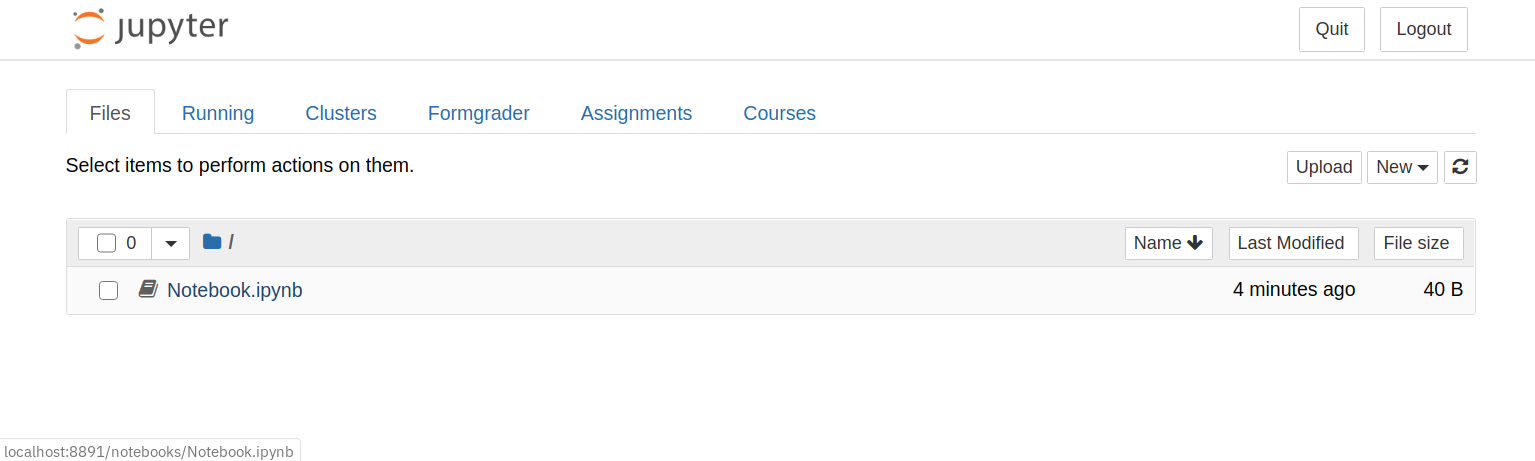

The JupyterLab interface looks like 

JupyterLab-grænsefladen ser ud som

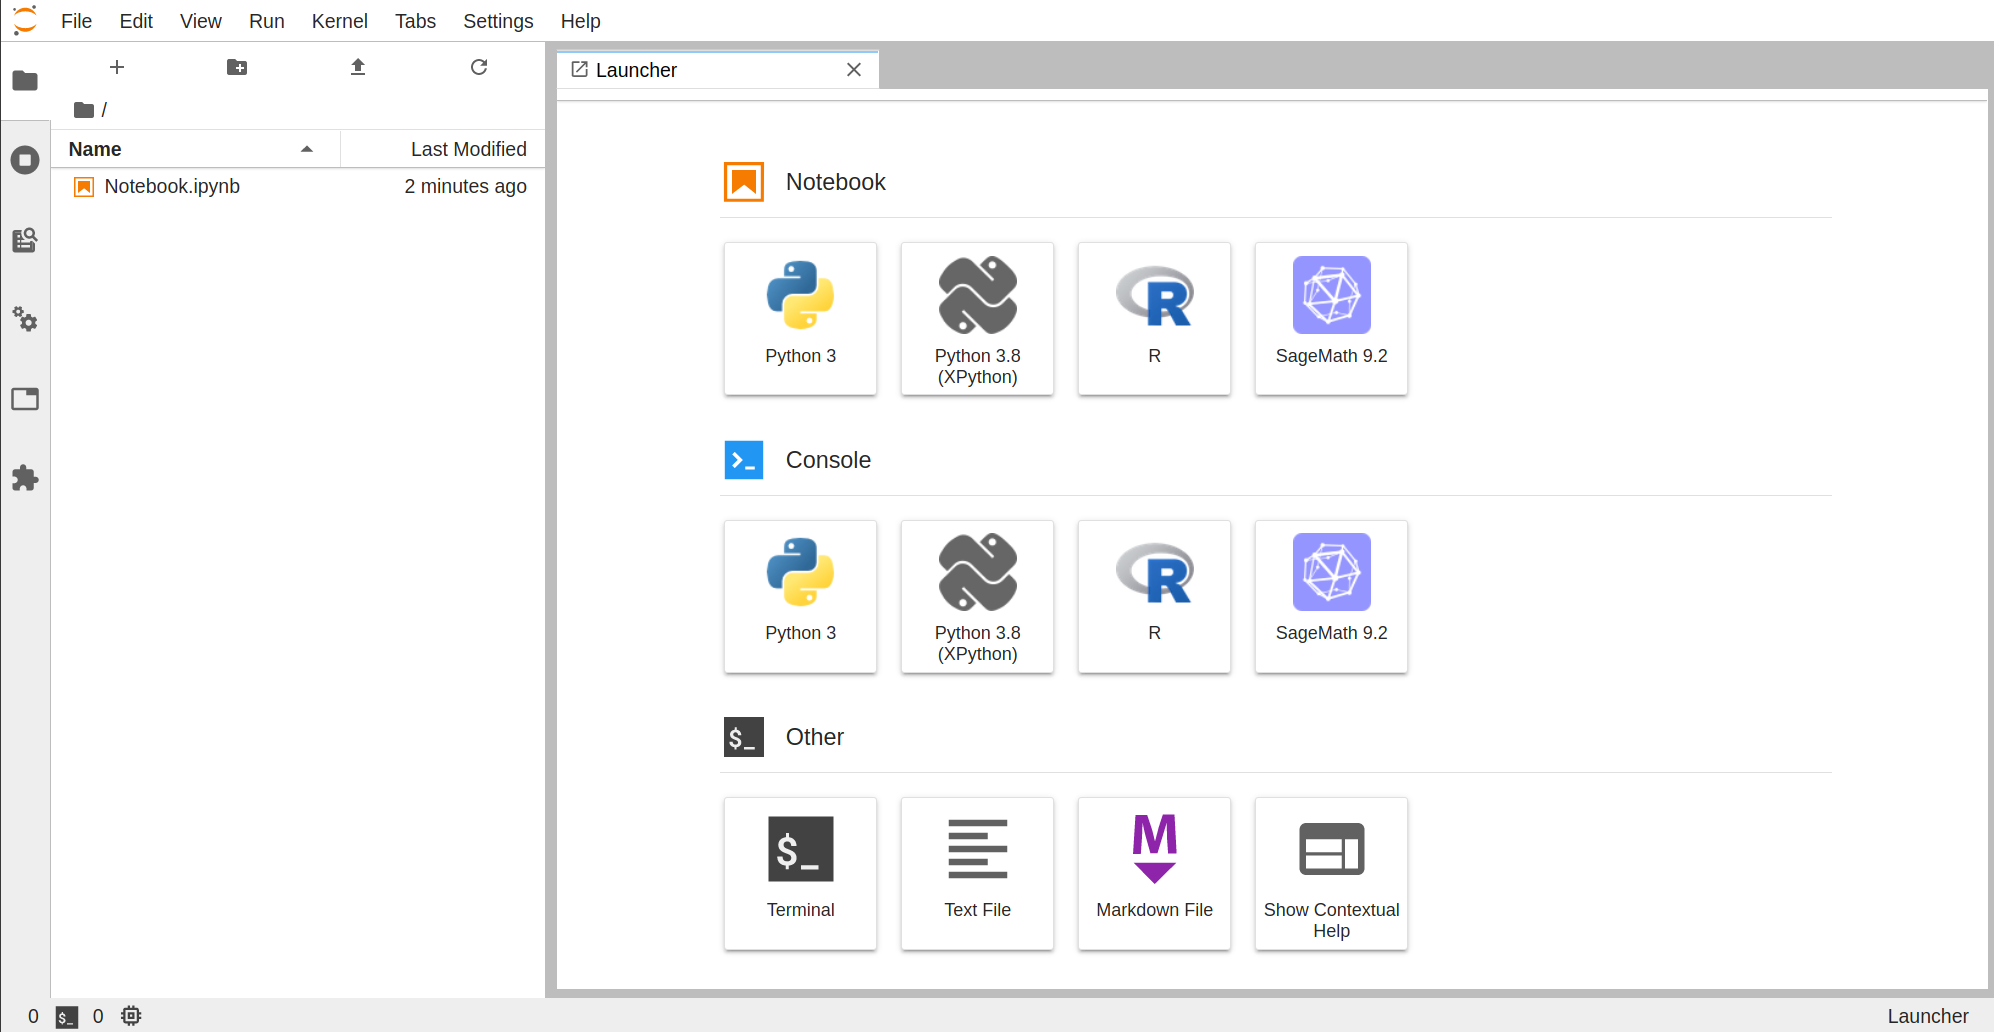

From these interfaces we can open existing notebooks - e.g., `Notebook.ipynb` by clicking them, or create a new Python 3 notebook by 

- Selecting _Python 3_ from the **New** drop-down menu in the classical interface, or 
- Clicking the _Python 3_ button in the JupyterLab interface. 

Fra disse grænseflader kan vi åbne eksisterende notesbøger - f.eks. `Notebook.ipynb` ved at klikke på dem eller oprette en ny Python 3 notesbog ved at

- Valg af _Python 3_ fra rullemenuen **Ny** i den klassiske grænseflade, eller
- Klik på knappen _Python 3_ i JupyterLab-grænsefladen.

If we open an existing notebook, we may for example see 

Hvis vi åbner en eksisterende notesbog, kan vi f.eks. se

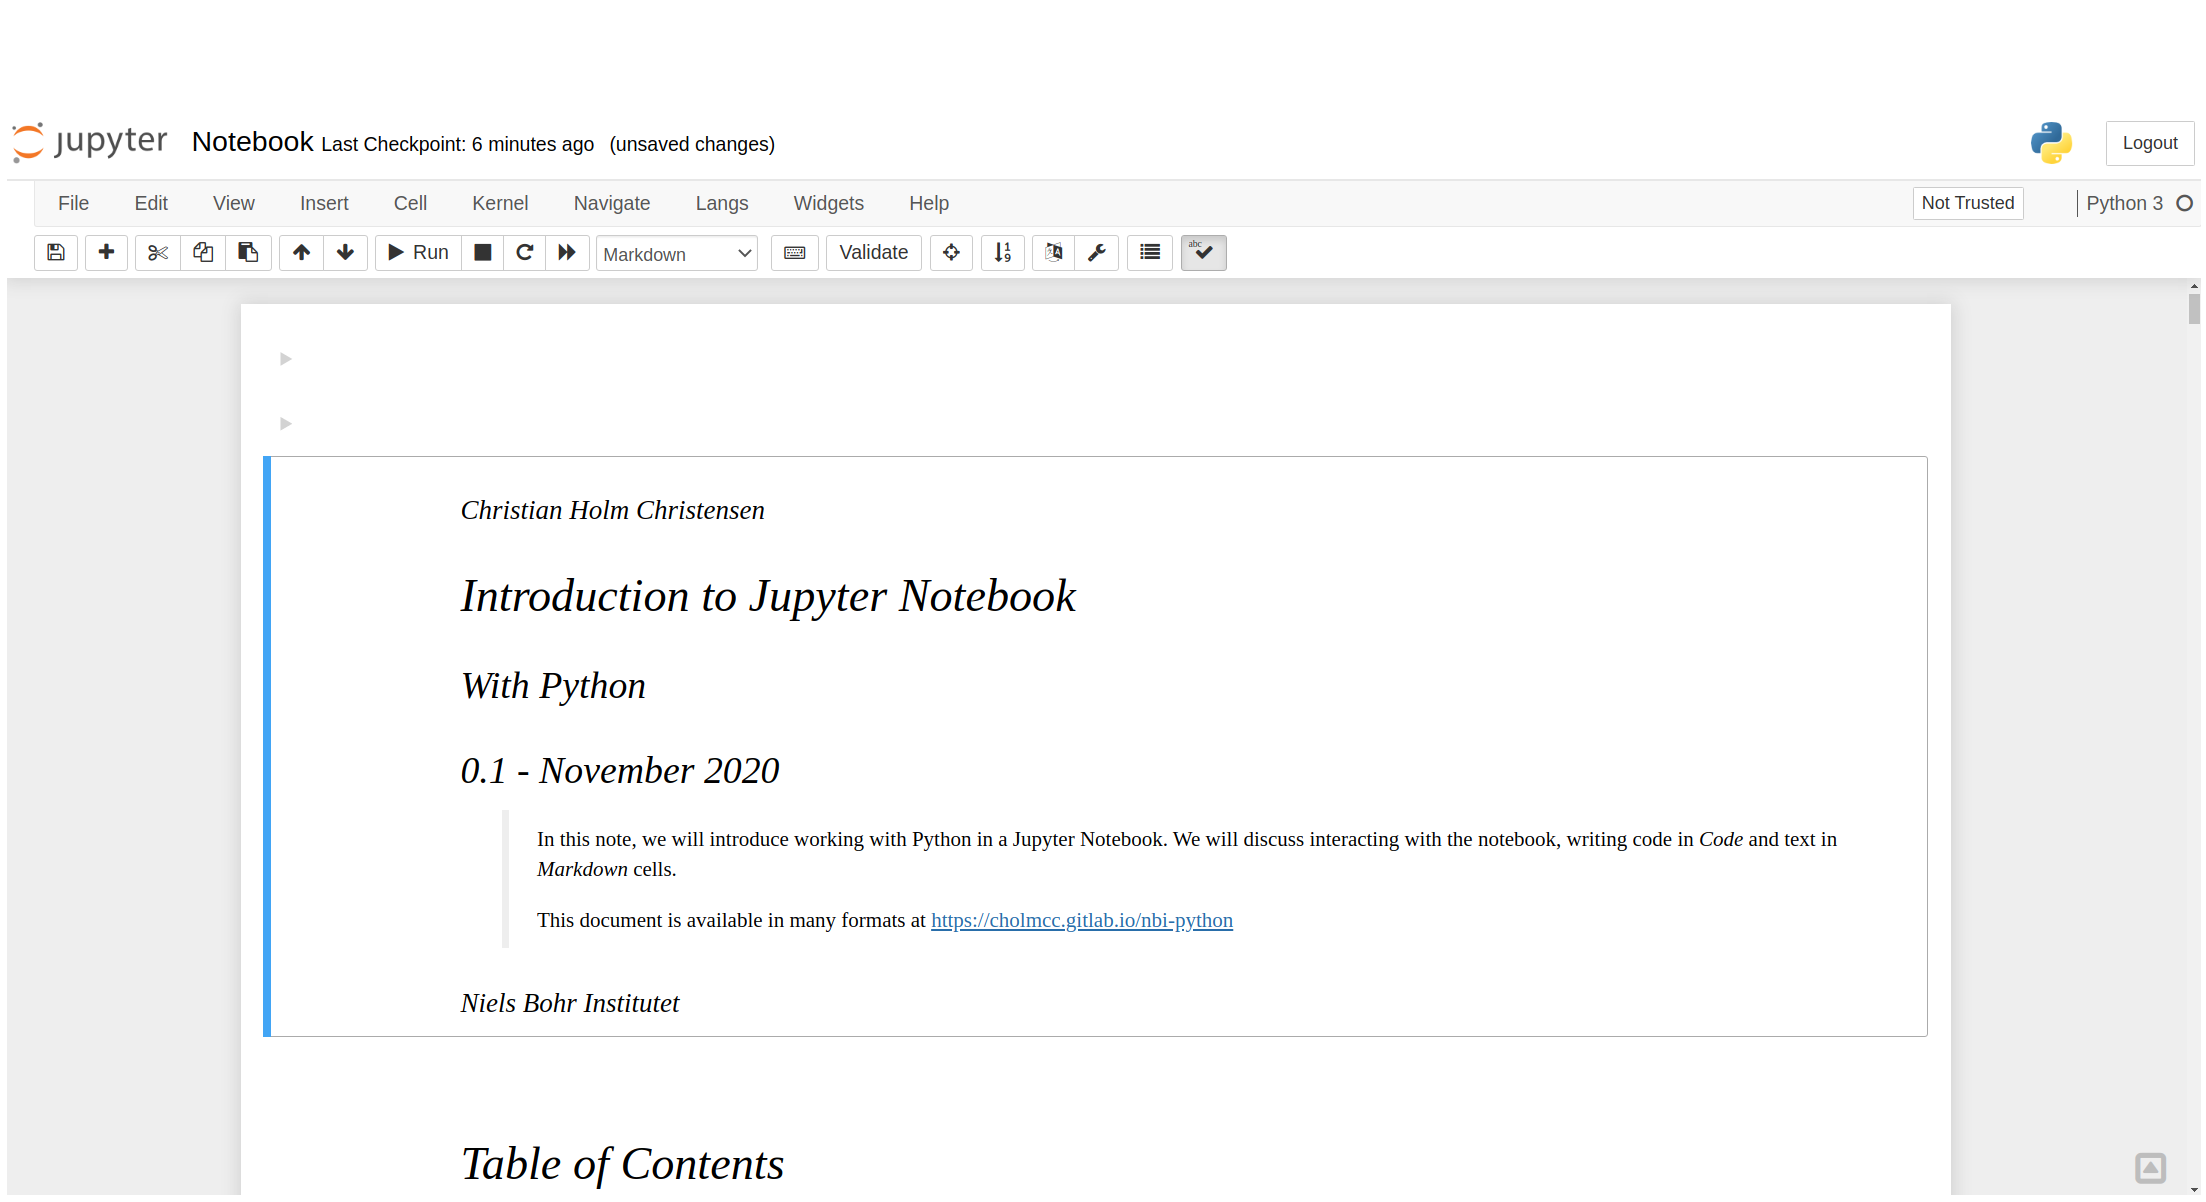

# Cells 

# Celler

A notebook consists of _cells_ as we already discussed.  Typically one will only use _Markdown_ and _Code_ type cells, but a third kind called _Raw NBConvert_ also exists.  This type is for advanced use, and we will not use it here. 

More on Notebook basics can be found [here](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Notebook%20Basics.html)

Initially when you start a new notebook you will have _one_ code cell. We will go into how to add, remove, and change the type of cell a little later, but first we need to talk about the _states_ a cell can be in. 

En notesbog består af _celler_ som vi allerede har snakket om. Typisk bruger man kun _Markdown_ og _Code_ type celler, men der findes også en tredje type kaldet _Raw NBConvert_. Denne type er til avanceret brug, og vi bruger den ikke her.

Mere om grundlæggende notesbøger kan findes [her](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Notebook%20Basics.html)

Først når du starter en ny notesbog, vil du have _en_ kodecelle. Vi vil undersøge, hvordan man tilføjer, fjerner og ændrer celletypen lidt senere, men først skal vi tale om de _tilstande_ en celle kan være i.

## State of a cell 

All types of cells can be in two states 

- Edit mode:  When the cell is in this state, we can edit the content of the cell.  Keystrokes are converted into plain text in the cell.  This state is typically indicated by a <span style='color:green'>green</span> highlight of the cell.  To leave this state press `Esc`.  One can enter _Edit mode_ from _Command mode_ by pressing `Enter` or clicking in the input field. 
- Command mode: When the cell is in this state, we can operate on the entire cell - for example copy it, move it around, delete the cell, and so on.  This state is typically indicated by a <span style='color:blue'>blue</span> highlight of the cell. One can enter _Edit mode_ by pressing `Enter`.  One can enter _Command_ mode by pressing `Esc` or clicking on the white field next to the input field. 

Different short-cut commands apply in each of these states.  See the menu item **Help->Keyboard shortcuts** for more. 

## Tilstand af en celle

Alle typer celler kan være i to tilstande

- Redigeringstilstand: Når cellen er i denne tilstand, kan vi redigere indholdet af cellen. Tastetryk konverteres til almindelig tekst i cellen. Denne tilstand er typisk angivet med en <span style='color:green'>green</span> fremhævning af cellen. For at forlade denne tilstand skal du trykke på `Esc`. Man kan gå ind i _Redigeringstilstand_ fra _Kommandotilstand_ ved at trykke på `Enter` eller klikke i indtastningsfeltet.
- Kommandotilstand: Når cellen er i denne tilstand, kan vi betjene hele cellen - for eksempel kopiere den, flytte den rundt, slette cellen osv. Denne tilstand er typisk angivet med en <span style='color:blue'>blue</span>-fremhævning i cellen. Man kan gå ind i _Redigeringstilstand_ ved at trykke `Enter`. Man kan gå ind i _Kommando_ -tilstand ved at trykke på `Esc` eller klikke på det hvide felt ved siden af inputfeltet.

Forskellige genvejskommandoer gælder i hver af disse tilstande. Se menupunktet **Hjælp-> Tastaturgenveje** for mere.

In addition to the two above states, each cell can either be _evaluated_ or _unevaluated_. 

- Evaluated: From either _Edit_ or _Command mode_ we can evaluate the cell.  To do that, one can press `Ctrl+Enter` or press the **Run** button in the button bar.  This will evaluate the content of the cell: For Markdown cells this means rendering the text, while for Code cells this will execute the code in the cell.  After evaluating the cell, the cell is put into _Command Mode_.

  Evaluated cells are indicated a little differently:  Markdown cells have their content rendered, while code cells have the execution count put into their `In []` prompt. 
  
  One can also evaluate a cell and select the next cell (or add one) by pressing `Shift+Enter`. 
  
- Unevaluated: When the content of a cell is edited it becomes _unevaluated_.  

  For _Markdown_ cells this is indicated by the content is not rendered. For _Code_ cells it is indicated by no execution count in its `In []` prompt. 

Ud over de to ovenstående tilstande kan hver celle enten være _evalueret_ eller _uevalueret_.

- Evalueret: Fra enten _Rediger_ eller _Kommandotilstand_ kan vi evaluere cellen. For at gøre det kan man trykke på `Ctrl+Enter` eller trykke på knappen **Run** i knapbjælken. Dette vil evaluere celleindholdet: For Markdown-celler betyder det gengivelse af teksten, mens det for kodeceller udfører koden i cellen. Efter evaluering af cellen sættes cellen i _Kommando-tilstand_.

  Evaluerede celler er angivet lidt anderledes: Markdown-celler får deres indhold gengivet, mens kodeceller får eksekveringstællingen sat i deres "In []" -prompt.
  
  Man kan også evaluere en celle og vælge den næste celle (eller tilføje en) ved at trykke på `Shift+Enter`.
  
- Uevalueret: Når indholdet af en celle redigeres, bliver den _uevalueret_.

  For _Markdown_ celler er dette angivet ved, at indholdet ikke gengives. For _kode_ celler er det angivet ved ingen eksekveringstælling i dens `In []` prompt.

## Adding and removing cells 

We can always add or remove cells from the menu **Edit**.  However, we can also use keyboard shortcuts when in _Command mode_: 

- `a` adds a cell below the current cell 
- `b` adds a cell above the current cell 
- `c` copies a cell and `v` inserts the copy after the current cell.  `Shift+v` inserts the copied cell above the current cell. 
- `dd` (two `d`s) deletes the current cell.  
- `z` undoes a delete of cells 

## Tilføjelse og fjernelse af celler

Vi kan altid tilføje eller fjerne celler fra menuen **Rediger**. Vi kan dog også bruge tastaturgenveje i _Kommandotilstand_:

- `a` tilføjer en celle under den aktuelle celle
- `b` tilføjer en celle over den aktuelle celle
- `c` kopierer en celle og `v` indsætter kopien efter den aktuelle celle. `Shift+v` indsætter den kopierede celle over den aktuelle celle.
- `dd` (to` d`er) sletter den aktuelle celle.
- `z` fortryder en sletning af celler

Another way of adding a cell is by splitting the current cell.  While in _Edit mode_, press `Ctrl+Shift+-` (that's a minus) and the cell will be split in two at the point of the cursor.  This is very useful to quickly insert a Markdown cell between two pieces of code, say for explaining some detail. 

One can also _evaluate_ and add another cell below the current cell by pressing `Alt+Enter`

En anden måde at tilføje en celle på er ved at opdele den aktuelle celle. Mens du er i _Redigeringstilstand_, skal du trykke på `Ctrl+Shift+-` (det er et minus), og cellen deles i to ved markørens punkt. Dette er meget nyttigt for hurtigt indsætte en Markdown-celle mellem to stykker kode, f.eks. for at forklare nogle detaljer.

Man kan også _evaluere_ og tilføje en anden celle under den aktuelle celle ved at trykke på `Alt+Enter`

## Changing type of a cell 

We can change the type (_Markdown_ or _Code_) of a cell when in _Command mode_.  

- `y` makes the cell into a _Code_ type cell 
- `m` makes it into a _Markdown_ type cell. 

(`r` changes to the _Raw_ type, but we don't use that). 

Alternatively one can use the button menu drop-down menu to change the type of the cell. 

Code cells are easily recognisable by the `In [ ]:` prompt to the left of the input field. 

## Ændring af en celle

Vi kan ændre typen (_Markdown_ eller _Kode_) af en celle, når vi er i _Kommandotilstand_.

- `y` gør cellen til en _kode_ type celle
- `m` gør det til en _Markdown_ type celle.

(`r` skifter til _Raw_ -typen, men det bruger vi ikke).

Alternativt kan man bruge rullemenuen i knapmenuen til at ændre celletypen.

Kodeceller kan let genkendes ved prompten `In []:` til venstre for indtastningsfeltet.

## Starting a notebook all over 

## Starte en notesbog forfra

It is very useful to sometimes start the notebook afresh.  By that, we do not mean delete all the content and write it again. Rather, we want to clear the memory and evaluate all cells again.  To do that, select from the menubar **Kernel->Restart and run all cells**.  This will reset everything and evaluate each cell in the notebook, starting from the top, sequentially.  

If there are errors in the notebook, this will typically prevent further processing of the cells.  One should _always_ apply this procedure before handing in or otherwise sharing a notebook. 

Det er meget nyttigt at en notesbog den bærbare computer fra en frisk. Med det mener vi ikke slette alt indholdet og skrive det igen. Vi ønsker snarere at rydde hukommelsen og evaluere alle celler igen. For at gøre det skal du vælge fra menulinjen **Kernel-> Restart and run all cells**. Dette nulstiller alt og evaluerer hver celle i notesbogen, startende fra toppen, sekventielt.

Hvis der er fejl i notesbogen, vil det typisk forhindre yderligere behandling af cellerne. Man skal _altid_ anvende denne procedure, inden man afleverer eller på anden måde deler en notesbog.

# Markdown 

_Markdown_ is a text formatting _mark-up_ language inspired by _de-facto_ standards from emails, use groups, and the like.   _Mark-up_ means that we mark the text in a special way and it is then _rendered_ into a more presentable text.   The _Markdown_ language is particularly simple and what we write is very human-readable, as we shall see.  Other examples of mark-up languages are HTML, $\mathrm{\LaTeX}$, RST, and so on. 

_Markdown_ er en tekstformatering _markerings_ (mark-up) sprog inspireret af _de facto_ standarder fra e-mails, brugsgrupper og lignende. _Mark-up_ betyder, at vi markerer teksten på en speciel måde, og den bliver derefter _gengivet_ til en mere præsentabel tekst. _Markdown_ sproget er særligt simpelt, og det, vi skriver, er meget læsbart, som vi skal se. Andre eksempler på markeringssprog er HTML, $\mathrm{\LaTeX}$, RST osv.

## Basic mark-up

## Grundlæggende markering

### Bold face 

Text is marked as **bold-face** by surrounding it with two asterisks `**` before and after that which we want to make **bold**.  That is 

~~~
    **This is bold face** 
~~~

becomes **This is bold face**

### Fed

Tekst er markeret som **fed** ved at omgive den med to stjerner `**` før og efter det, som vi vil gøre **fed**. For eksempel

~~~
    **Dette er fed skrift**
~~~

bliver **Dette er fed skrift**

### Emphasis 

_Emphasis_ is achieved by surrounding with an underscore `_` before and after the text.  For example 

~~~
    _This is emphasized_
~~~

becomes _This is emphasized_

### Vægt

_Vægt tekst_ opnås ved at omgive med en understregning `_` før og efter teksten. For eksempel

~~~_ 
    Dette understreges
~~~

bliver_ Dette understreges_

### Strike-out 

We can ~~strike-out~~ text by preceding and postceding the text with two tildes `~~`.  That is

~~~
    ~~This text is stricken out~~ 
~~~

gives ~~This text is stricken out~~. 

### Overstreget

Vi kan ~~strege~~ tekst ud ved at foran og bagved indsætte to _tilde_ `~~`.  

~~~
    ~~Denne tekst er overstreget~ ~
~~~

giver ~~Denne tekst er overstreget~~.

### Literal text 

If we want to add literal text we can surround the text with one or more backticks `` ` ``.  This is useful when we want to refer to variables, functions, or the like, in our code.  So for example 

~~~
    `This is literal text` 
~~~

becomes `This is literal text`

### Bogstavelig tekst

Hvis vi vil tilføje bogstavelig tekst, kan vi omgive teksten med en eller flere backticks `` ` ``. Dette er nyttigt, når vi vil henvise til variabler, funktioner eller lignende i vores kode. Så for eksempel

~~~
    `Dette er bogstavelig tekst`
~~~

bliver `Dette er bogstavelig tekst`

### Block literal text 

If we want to include a literal block of text, we can do so by indenting all lines by at least 4 spaces 

```
    This text is indented by 4 spaces 
    So is this. 
```

yielding 

    This text is indented by 4 spaces 
    So is this. 

### Blokke af bogstavelig tekst

Hvis vi vil inkludere en bogstavelig tekstblok, kan vi gøre det ved at indrykke alle linjer med mindst 4 mellemrum

```
    Denne tekst er indrykket af 4 mellemrum
    Også dette.
```

hvilket giver

    Denne tekst er indrykket af 4 mellemrum
    Også dette.

Again, this is useful if we are commenting on code, writing examples, or the like.  If we want to give code in a specific language as literal text, for example C++, we can use `` ```C++ `` before the block and end with `` ``` `` after the block. Note, the block _must not_ be indented. For example 

~~~
    ```C++
    #include <iostream>
    
    int main() 
    {
      std::cout << "Hello, world" << std::endl;
      return 0;
    }
    ```
~~~
    
gives 

```C++
#include <iostream>

int main() 
{
  std::cout << "Hello, world" << std::endl;
  return 0;
}
``` 

Igen er dette nyttigt, hvis vi kommenterer kode, eksempler eller lignende. Hvis vi vil give kode på et bestemt sprog, for eksempel C ++, kan vi bruge `` ```C ++ `` før blokken og slutte med `` ``` `` efter blokken. Bemærk, blokken _må ikke_ være indrykket. For eksempel

~~~
    ```C ++
    # inkluderer <iostream>
    
    int main ()
    {
      std :: cout << "Hello, world" << std::endl;
      return 0;
    }
    ```
~~~
    
som giver

```C++
#include <iostream>

int main ()
{
  std :: cout << "Hej, verden" << std :: endl;
  returnere 0;
}
```

### Horizonal divider 

We can make a horizontal line (divider) by entering three or more dashes `-` on a line by it self 

```
    --- 
```

This gives 

---

This can be useful for dividing up the text around separate topics

### Vandret skillelinje

Vi kan lave en vandret linje (skillelinje) ved at indtaste tre eller flere bindestreger `-` på en linje af sig selv

```
    ---
```

Dette giver

---

Dette kan være nyttigt til opdeling af teksten omkring separate emner

## Lists 

## Lister

### Unordered lists 

Bulleted lists can be entered by putting a dash `-` or asterisk as the first character of a new line.  For example 

~~~
    - This is a bullet 
    - This is another bullet 
~~~

will render as 

- This is a bullet 
- This is another bullet 

### Uordnede lister

Punkt med lister kan angives ved at sætte en bindestreg `-` eller stjerne som det første tegn i en ny linje. For eksempel

```
    - Dette er et punkt
    - Dette er endnu et punkt
```

vil gengive som

- Dette er et punkt
- Dette er endnu et punkt

### Ordered (numbered) lists 

We can make numbered lists by starting a line with a number followed by a period `.`.  For example 

```
    1. First item 
    1. Second item 
    4. Third item 
```

will give us 

1. First item 
1. Second item 
4. Third item 

Note that the actual number is irrelevant.  The list will always be sequential.   One therefor often put `1` as the number.  

### Ordnet (nummererede) lister

Vi kan oprette nummererede lister ved at starte en linje med et tal efterfulgt af et punktum `.` For eksempel

```
    1. Første emne
    1. Andet emne
    4. Tredje emne
```

vil give os

1. Første emne
1. Andet emne
4. Tredje emne

Bemærk, at det tallet er irrelevant. Listen vil altid være sekventiel. Man bruger derfor ofte `1` som tallet.

### Sub (or nested) lists

An entry in a list (ordered or unordered) can be another list (ordered or unordered) to form a sub-list.  All we need to do is to indent the sub-list by at least 2 spaces relative to the parent list.  Thus 

```
    - A bullet 
    - Another bullet with a sub-list 
      - Sub thing 
      - Another sub-thing
    - More items 
    - We can add many levels 
      - Sub-list item 
        - Sub-sub list item 
          - Sub-sub-sub item 
```

Gives us 

- A bullet 
- Another bullet with a sub-list 
  - Sub thing 
  - Another sub-thing
- More items 
- We can add many levels 
  - Sub-list item 
    - Sub-sub list item 
      - Sub-sub-sub item 

### Sub (eller indlejrede) lister

En post på en liste (bestilt eller ikke-ordnet) kan være en anden liste (bestilt eller ikke-ordnet) for at danne en underliste. Alt hvad vi skal gøre er at indrykke underlisten med mindst 2 mellemrum i forhold til forældrelisten. Dermed

```
    - Et punkt
    - Et andet punkt med en underliste
      - Sub emne
      - Et andet sub-emne
    - Flere emner
    - Vi kan tilføje mange niveauer
      - Under element
        - Under-under element
          - Under-under-under element
```

Giver os

- Et punkt
- Et andet punkt med en underliste
  - Sub emne
  - Et andet sub-emne
- Flere emner
- Vi kan tilføje mange niveauer
  - Under element
    - Under-under element
      - Under-under-under element

We can mix ordered and unordered lists as we see fit 

```
    1. A bullet 
    1. Another bullet with a sub-list 
       - Sub thing 
       - Another sub-thing
    1. More items 
    1. We can add many levels 
       1. Sub-list item 
          1. Sub-sub list item 
             - Sub-sub-sub item
             - Sub-sub-sub item
          1. Sub-sub list item 
       1. Sub-list item 
       -  Sub-list item 
```

gives

1. A bullet 
1. Another bullet with a sub-list
   - Sub thing 
   - Another sub-thing
1. More items 
1. We can add many levels 
   1. Sub-list item 
      1. Sub-sub list item 
         - Sub-sub-sub item
         - Sub-sub-sub item
      1. Sub-sub list item 
   1. Sub-list item
   -  Sub-list item  

Vi kan blande ordnede og ikke-ordnede lister

```
    1. Et punkt
    1. Et andet punkt med en underliste
       - Sub emne
       - Et andet sub-emne
    1. Flere punkter
    1. Vi kan tilføje mange niveauer
       1. Under punkt
          1. Under-under punkt
             - Under-under-under punkt
             - Under-under-under punkt
          1. Under-under punkt
       1. Under punkt
       - Under punkt
```

giver

1. Et punkt
1. Et andet punkt med en underliste
   - Sub emne
   - Et andet sub-emne
1. Flere punkter
1. Vi kan tilføje mange niveauer
   1. Under punkt
      1. Under-under punkt
         - Under-under-under punkt
         - Under-under-under punkt
      1. Under-under punkt
   1. Under punkt
   - Under punkt

## Tables

We can make simple tables in _Markdown_. Remember, _Markdown_ is based on practices around the Internet where people used plain text to communicate content (such as emails or use groups).  The support for tables is therefore a little rudimentary but good enough for most purposes. 

A Table in Jupyter _Markdown_ _always_ has a header row followed by a divider and then body rows.  For example 

## Tabeller

Vi kan lave simple tabeller i _Markdown_. Husk, _Markdown_ er baseret på praksis på Internettet, hvor folk brugte almindelig tekst til at kommunikere indhold (såsom e-mails eller bruger grupper). Understøttelse af tabeller er derfor lidt rudimentær, men god nok til de fleste formål.

En tabel i Jupyter _Markdown_ har _altid_ en titelrække efterfulgt af en linje og derefter rækker. For eksempel

```
    | Parameter | Value                              |
    |:----------|:----------------------------------:|
    | Question  | Life, the universe, and everything |
    | Answer    | 42                                 |
```

will give 

giver

| Parameter | Value                              |
|:----------|:----------------------------------:|
| Question  | Life, the universe, and everything |
| Answer    | 42                                 |

### Cell alignment 

The horizontal alignment of cells (elements of each row) is specified by colons `:` in the divider line. Above the **Parameter** column was left-justified by the single `:` to the left in the divider, and **Value** centred by `:` at each end of the divider.  Here's another example 

### Cellejustering

Den vandrette justering af celler (elementer i hver række) specificeres af kolon `:` i skillelinjen. Ovenover blev **Parameter** -kolonnen venstrejusteret af enkelt `:` til venstre i skillelinjen og **Værdi** centreret af `:` i hver ende af skillelinjen . Her er et andet eksempel

```
    | Left | Right | Centred | No choice |
    |:-----|------:|:-------:|-----------|
    | a    | b     | c       | d         |
```    

which yields 

som giver

| Left | Right | Centred | No choice |
|:-----|------:|:-------:|-----------|
| a    | b     | c       | d         |

## Quotes 

If we want to quote something, we can start each line of the quote with a greater-than symbol `>` (remember, _Markdown_ encodes practices from email among other things).   For example 

```
    > Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore 
    > et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut 
    > aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse 
    > cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in 
    > culpa qui officia deserunt mollit anim id est laborum.
``` 

gives 

> Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore 
> et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut 
> aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum
> dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui 
> officia deserunt mollit anim id est laborum.

## Citater

Hvis vi vil citere noget, kan vi starte hver linje i citatet med et større-end symbol `>` (husk, _Markdown_ indkoder blandt andet praksis fra e-mail). For eksempel

```
    > Lorem ipsum dolor sid amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore
    > et dolore magna aliqua. Ud enim ad minim veniam, quis nostrud motion ullamco laboris nisi ut
    > aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse
    > cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in
    > culpa qui officia deserunt mollit anim id est laborum.
```

giver

> Lorem ipsum dolor sid amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore
> et dolore magna aliqua. Ud enim ad minim veniam, quis nostrud motion ullamco laboris nisi ut
> aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum
> dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui
> officia deserunt mollit anim id est laborum.

I like to use quotes like this to comment on student assignments.  It makes the comments standout and thus easy to find. 

Jeg kan godt lide at bruge citater som dette til at kommentere studerendes opgaver. Det gør kommentarerne skiller sig ud og dermed lette at finde.

One can use all the regular _Markdown_ mark-up in quotes 

```
    > In this quote, we _emphasise_ this **point**
```

which gives 

> In this quote, we _emphasise_ this **point**

Man kan bruge al den almindelige _Markdown_ markering i citater

```
    > I dette citat _understreger_ vi dette **punkt**
```

hvilket giver

> I dette citat _understreger_ vi dette **punkt**

## Paragraphs 

One starts a new paragraph by leaving a blank line between the two paragraphs. 

```
    This is the first paragraph 
    
    And this is the second
```

This renders as 

---

This is the first paragraph 
    
And this is the second

---

(lines added)

## Paragrafer 

Man starter et nyt afsnit ved at efterlade en tom linje mellem de to afsnit.

```
    Dette er første afsnit
    
    Og dette er det andet
```

Dette gengives som

---
Dette er første afsnit
    
Og dette er det andet

---

(tilføjede linjer)

## Images 

### Embedded images

The best way to add an image is to use the menu item **Edit -> Insert image**.  That will _embed_ the image into the Jupyter Notebook and insert mark-up for including the image.  

```
    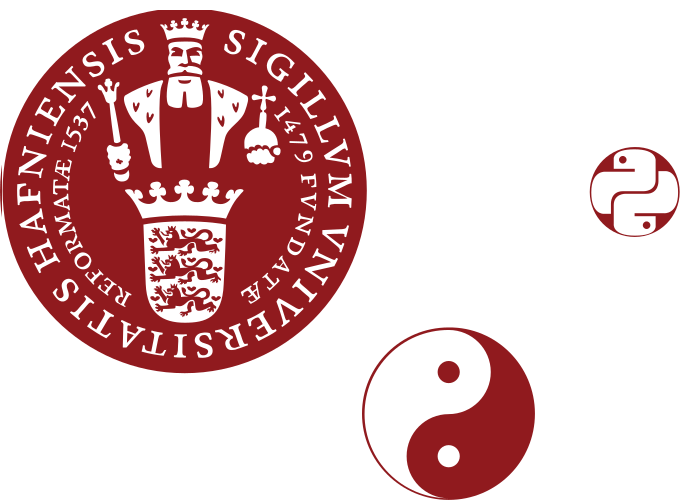
``` 

which will give 

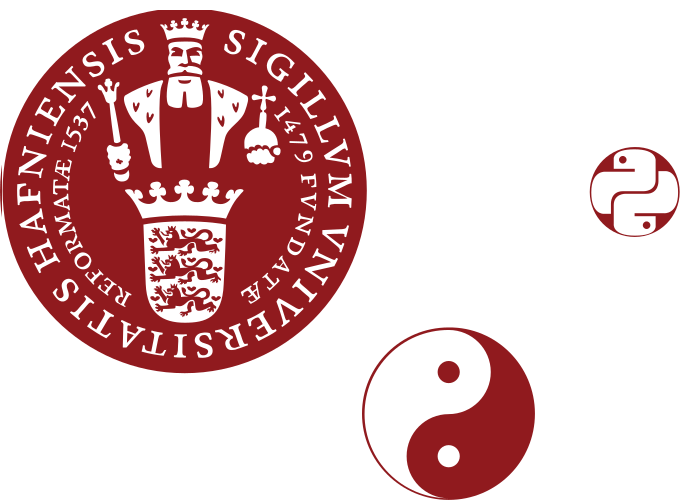

## Billeder

### Indlejrede billeder

Den bedste måde at tilføje et billede på er at bruge menupunktet **Edit -> Insert image**. Det vil _indlejre_ billedet i Jupyter Notebook og indsætte markering for at inkludere billedet.

```
    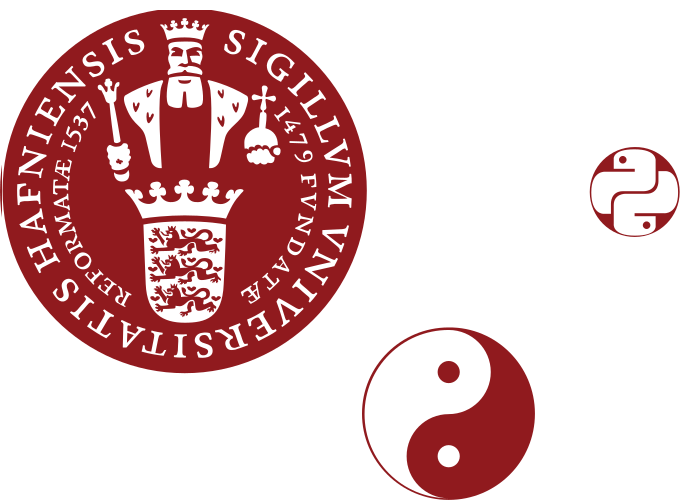
```

som vil give

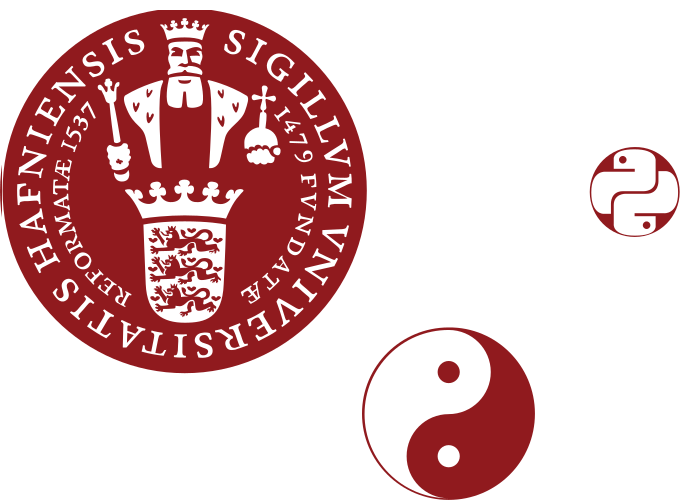

### External images 

We can also include external images.  Note that these are not part of the Jupyter Notebook and we need to make sure to copy them along if we distribute the notebook.  To include an external image, do 

```
    ![A Maine-Coon](mainecoon.jpg)
```

![A Maine-Coon](mainecoon.jpg)

### Eksterne billeder

Vi kan også inkludere eksterne billeder. Bemærk, at disse ikke er en del af notesbogen, og vi skal sørge for at kopiere dem med, hvis vi distribuerer notesbogen. For at inkludere et eksternt billede skal du skrive

```
    ![A Maine-Coon](mainecoon.jpg)
```

![A Maine-Coon](mainecoon.jpg)

## Headings 

We can make section headings by preceding the title by one or more hashes `#` and a space.  One `#` gives the top-level sectioning, two `##` the second level, and so on.  For example 

```
    # A Section 
    ## A Sub-section 
    ### A Sub-sub-section
```

Here, we will not show the output directly, but the below will give an idea.

```
# A Section 
## A Sub-section 
### A Sub-sub-section
```



## Overskrifter

Vi kan lave sektionsoverskrifter ved at skrive en eller flere havelåger `#` og et mellemrum foran titlen. En `#` giver sektionen på øverste niveau, to `##` det andet niveau og så videre. For eksempel

```
    # Et afsnit
    ## Et under-afsnit
    ### Et under-under-afsnit
```

Her viser vi ikke output direkte, men nedenunder giver en idé.

```
# Et afsnit
## Et under-afsnit
### Et under-under-afsnit
```

## Links 

### External links 

We can link to external web-pages, for example to give a reference or more information.  For example 

```
    [arXiv](https://arxiv.org)
``` 

generates a link to the pre-print server _arXiv_ 

[arXiv](https://arxiv.org)

We can also link to external files.  For example 

```
    [An image](mainecoon.jpg)
``` 

which will open that file 

[An image](mainecoon.jpg)

Note, external links always open in a new browser window or tab. 

## Henvisninger

### Eksterne henvisninger

Vi kan henvise til eksterne websider, for eksempel for at give en reference eller mere information. For eksempel

```
    [arXiv](https://arxiv.org)
```

genererer en henvisning til pre-print-serveren _arXiv_

[arXiv](https://arxiv.org)

Vi kan også henvise til eksterne filer. For eksempel

```
    [Et billede](mainecoon.jpg)
```

som åbner filen

[Et billede](mainecoon.jpg)

Bemærk, eksterne links åbnes altid i et nyt browservindue eller en ny fane.

### Internal links 

We can link to any sectioning heading we have defined in our notebook. For example 

``` 
    [More on **Bold face**](#Bold_face)
``` 

gives us a link to the sub-section on **bold face** mark-up.  Note that special characters are replaced by a dash `-`.

[More on **Bold face**](#Bold-face)

### Interne henvisninger

Vi kan henvise til en hvilken som helst sektionsoverskrift, som vi har defineret i vores notesbog. For eksempel

```
    [Mere om `Bogstavelig tekst`](#Bogstavelig-tekst)
```

giver os en henvising til underafsnittet om `bogstavelig tekst`. Bemærk, at specialtegn erstattes af en streg `-`.

[Mere om `Bogstavelig tekst`](#Bogstavelig-tekst)

## Mathematics 

_Markdown_ in Jupyter Notebook has built-in support for $\mathrm{\LaTeX}$ mathematics - the de-facto typesetting system for scientific papers - especially in Mathematics and Physics.  Math comes in two flavours 

- In-line math.  That is, math which is part of the normal flow of the text. 
- Display math. That is, math which is centred and with additional white space above and below.

For example, here is some in-line math $a^2+b^2=c^2$, and some display math 

$$f(x) = \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac12\frac{(x-\mu)^2}{\sigma^2}}\quad.$$

For now, do not worry about the $\mathrm{\LaTeX}$ code.  We will give some examples a little later.

## Matematik

_Markdown_ i Jupyter Notebook har indbygget understøttelse af $\mathrm{\LaTeX}$ matematik - den _de-facto_ tegnsætningssystem i videnskabelige artikler - især inden for matematik og fysik. Matematik findes i to varianter

- I-linje matematik. Det vil sige matematik, som er en del af den normale strøm af tekst.
- Vist matematik. Det vil sige matematik, der er centreret og med ekstra hvidt mellemrum over og under.

For eksempel er her noget i-linje matematik $a^2+b^2=c^2$ og noget vist matematik

$$f(x) = \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac12\frac{(x-\mu)^2}{\sigma^2}}\quad.$$

For øjeblikket skal du ikke bekymre dig om $\mathrm{\LaTeX}$-koden. Vi vil give nogle eksempler lidt senere.

### In-line math 

In a _Markdown_ cell we may enter in-line math by surrounding our $\mathrm{LaTeX}$ code with dollar signs `$`. 

``` 
    Here is some in-line math $a^2+b^2=c^2$ 
``` 

which then gives: 

Here is some in-line math $a^2+b^2=c^2$

### I-linje matematik

I en _Markdown_-celle kan vi indtaste i-linje matematik ved at omgive vores $\mathrm{\LaTeX}$-kode med dollartegn `$`. 

``` 
    Her er noget i-linje matematik $a^2 + b^2 = c^2$ 
``` 

som giver 

Her er noget i-linje matematik $a ^ 2 + b ^ 2 = c ^ 2$ 

### Display math 

Display math can be entered in a variety of ways depending on the math one wants to show.  The simplest form is to surround the math with double dollar signs `$$`.  

~~~ 
    $$f(x) = \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac12\frac{(x-\mu)^2}{\sigma^2}}\quad.$$
~~~

which typesets the probability density function of a normal distribution 

$$f(x) = \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac12\frac{(x-\mu)^2}{\sigma^2}}\quad.$$

### Vist matematik

Vist matematik kan indtastes på forskellige måder afhængigt af den matematik, man vil vise. Den enkleste form er at omgive matematikken med dobbelte dollartegn `$$`.  

~~~ 
    $$f(x) = \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac12\frac{(x-\mu)^2} {\sigma^2}}\quad.$$
~~~

som fremviser sandsynlighed tæthedsfunktionen for en normal fordeling 

$$f(x) = \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac12\frac{(x-\mu)^2} {\sigma^2}}\quad.$$

Another way is to use the $\mathrm{\LaTeX}$ _environments_ - the simplest of which is `equation` 

~~~
    \begin{equation}
      a^2+b^2=c^2
    \end{equation}
~~~ 

which gives us Pythagoras' theorem 

\begin{equation}
  a^2+b^2=c^2
\end{equation}


En anden måde er at bruge $\mathrm{\LaTeX}$ _miljøer_ - den enkleste er `equation`

~~~
    \begin{equation}
      a^2+b^2=c^2
    \end{equation}
~~~

hvilket giver os Pythagoras' sætning

\begin{equation}
  a^2+b^2=c^2
\end{equation}

If we want to display many equations or a continued equation - for example as we derive a result, we can use the environment `align`. 

~~~ 
    \begin{align}
      \mathbf{\nabla}\cdot\mathbf{D} &=4\pi\rho_{f}
      & \mathbf{\nabla}\times\mathbf{E} &=-\frac{\partial\mathbf{B}}{\partial t}\\
      \mathbf{\nabla}\cdot\mathbf{B} &=0
      & \mathbf{\nabla}\times\mathbf{H} &=\mathbf{J}_f
      +\frac{\partial\mathbf{D}}{\partial t}
    \end{align}
~~~

Maxwell said

Maxwell sagde

\begin{align}
  \mathbf{\nabla}\cdot\mathbf{D} &=4\pi\rho_{f}
  & \mathbf{\nabla}\times\mathbf{E} &=-\frac{\partial\mathbf{B}}{\partial t}\\
  \mathbf{\nabla}\cdot\mathbf{B} &=0
  & 
  \mathbf{\nabla}\times\mathbf{H} &=\mathbf{J}_f
  +\frac{\partial\mathbf{D}}{\partial t}
\end{align}

and there was light.

og der var lys.

In the `align` environment, ampersands `&` divide columns and two backslashes `\\` divide rows.  Note, columns are alternating between right and left alignment (in that order).  

I `align`-miljøet opdeler og-tegn `&` kolonner og to backslash `\ `opdeler rækker. Bemærk, kolonner skifter mellem højre og venstre justering (i den rækkefølge).

We can also use `align` to show a derivation. 

Vi kan også bruge `align` til at vise en udledning.

```
    \begin{align}
       (a+b)(a-b) &= a(a-b)+b(a-b)\\
                  &= a^2-ab+ba-b^2\\
                  &= a^2-b^2
    \end{align}
```

simply becomes

bliver

\begin{align}
   (a+b)(a-b) &= a(a-b)+b(a-b)\\
              &= a^2-ab+ba-b^2\\
              &= a^2-b^2
\end{align}

### A little bit of $\mathrm{\LaTeX}$

### En lille smule $\mathrm{\LaTeX}$

| Code             | Result         | Comment                  |
|:----------------:|:--------------:|:-------------------------|
| `a^p`            | $a^p$          | Power/superscript        |
| `\sqrt{a}`       | $\sqrt{a}$     | Root                     |
| `\sqrt[n]{a}`    | $\sqrt[n]{a}$  | $n$th-Root               |
| `\frac{a}{b}`    | $\frac{a}{b}$  | Fraction                 |
| `a_{b}`          | $a_{b}$        | Subscript                |
| `\int`           | $\int$         | Integral                 |
| `\int_{a}^{b}`   | $\int_a^b$     | Definite integral        |
| `\sum_{i=1}^{N}` | $\sum_{i=1}^N$ | Sum                      |
| `\mu`            | $\mu$          | Greek letter             |
| `\sin\theta`     | $\sin\theta$   | Sine of $\theta$         |
| `\log(b)`        | $\log(b)$      | Logarithm                |
| `\rightarrow`    | $\rightarrow$  | An arrow                 |
| `\mathbf{a}`     | $\mathbf{a}$   | Bold-face                |
| `\mathrm{kin}`   | $\mathrm{kin}$ | Roman text               |
| `\text{Text}`    | $\text{Text}$  | Normal text in math      |
| `\vec{v}`        | $\vec{v}$      | A vector                 |
| `\overline{x}`   | $\overline{x}$ | Bar over                 |

$\mathrm{\LaTeX}$ is typeset by `$\mathrm{\LaTeX}$`

$\mathrm{\LaTeX}$ kan opnås med `$\mathrm{\LaTeX}$`

# Code

# Kode

Code cells is where we enter our - well - code.  Here we are working with Python, so our code cells will contain Python code. 

Code cells are easily recognisable by the `In [ ]:` prompt to the left of the input field. 

Kodeceller er der, hvor vi indtaster vores kode. Her arbejder vi med Python, så vores kodeceller indeholder Python-kode.

Kodeceller kan let genkendes ved prompten ʻIn []:` til venstre for indtastningsfeltet.

An empty code cells does absolutely nothing, but has no point either, so we would normally remove them. 

En tom kodecelle gør absolut ingenting, men har heller ikke noget formål, så vi vil normalt fjerne dem.

When we enter text into a code cell, we are supposed to enter valid code. If what we enter isn't valid, then we will get an error when we evaluate the cell. 

Når vi indtaster tekst i en kodecelle, skal vi indtaste en gyldig kode. Hvis det, vi indtaster, ikke er gyldigt, får vi en fejl, når vi evaluerer cellen.

## Using the notebook as a calculator 

## Brug af en notesbog som en lommeregner

Here we will familiarise ourselves with code in a Jupyter Notebook by using it as a (overblown) calculator. 

We enter `2 + 2` in a code cell. We do not evaluate it just yet.  

Her vil vi gøre os bekendt med kode i en Jupyter Notebook ved at bruge den som en (opblæst) lommeregner.

Vi indtaster `2 + 2` i en kodecelle. Vi evaluerer det ikke endnu.

In [2]:
2+2

4

We notice is that the Notebook does _syntax highlighting_.  That is, the numbers and the plus sign have different colours or typographic style. This helps us quickly identify elements of the code we wrote. 

Secondly, we can see that the cell has not yet been evaluated by the prompt `In [ ]:` to the left.  That is, there is no number in the square brackets `[ ]`. 

Vi bemærker, at notesbogen laver _syntaks fremhævning_. Det vil sige, tallene og plustegnet har forskellige farver eller typografisk stil. Dette hjælper os med hurtigt at identificere elementer i den kode, vi skrev.

For det andet kan vi se, at cellen endnu ikke er evalueret af prompten 'In []:' til venstre. Det vil sige, der er ikke noget tal i firkantede parenteser [].

Let us evaluate the cell. 

Lad os evaluere cellen.

In [3]:
2+2

4

We see several things 

- First of all, we see that a number was put into the `In [2]` prompt to the left of our code.  The number reflects which number code cell this cell was executed as.  So if we had evaluated 9 code cells before this one, we would get the number `10` between the brackets as this whould be the tenth cell evaluated. 
(I play tricks with this notebook, which is why you see the number `2` here). 
- Secondly, a block was added after our cell with an `Out [2]` prompt to the left.  The notebook will _automatically_ show the result of the last operation of the cell (if there is one) and put it in an output field as above.  In this way, we can simply enter our calculations into cell and evaluate it to get the result (there are other ways involving `print`ing or `display`ing but we will try to avoid those as much as possible). 

Vi ser flere ting

- Først og fremmest ser vi, at et nummer blev sat ind i `In [2]` -prompten til venstre for vores kode. Nummeret afspejler, hvilken nummer kodecelle denne celle blev evalueret som. Så hvis vi havde vurderet 9 kodeceller før denne, ville vi få tallet `10` mellem parenteserne, da dette ville være den tiende celle, der blev evalueret.
(Jeg laver tricks med denne notesbog, hvorfor du ser nummeret '2' her).
- For det andet blev der tilføjet en blok efter vores celle med en `Out [2]` prompt til venstre. Notesbogen _viser automatisk_ resultatet af den sidste operation af cellen (hvis der er en) og placerer den i et ud-felt som ovenfor. På denne måde kan vi blot indtaste vores beregninger i celle og evaluere det for at få resultatet (der er andre måder, der involverer `print` eller `display`, men vi vil forsøge at undgå dem så meget som muligt).

What is written in the output field is considered the value of the last cell.  We can retrieve this value using the special name `_`

Hvad der skrives i outputfeltet betragtes som værdien af ​​den sidste celle. Vi kan hente denne værdi ved hjælp af det specielle navn `_`

In [4]:
_

4

In fact, we can get back _any_ value of an `Out []:` field by adding the number to `_`.  So for example, if we wanted the result number 10, we could get it with `_10`.   

Typically we will not use that, but in certain circumstances it can be really useful. 

Faktisk kan vi få tilbage _en hvilken som helst_ værdi af et `Out []:` felt ved at tilføje tallet til `_`. Så for eksempel, hvis vi ønskede resultatet nummer 10, kunne vi få det med `_10`.

Typisk vil vi ikke bruge det, men under visse omstændigheder kan det være virkelig nyttigt.

Let us do a few more simple calculations 

Lad os lave nogle flere enkle beregninger

We calculate 2-2

Vi beregner 2-2

In [5]:
2-2

0

Then $2\cdot 3$

Derefter $2\cdot 3$

In [6]:
2*3

6

and $\frac83$

og $\frac{8}{3}$

In [7]:
8/3

2.6666666666666665

We can also raise 2 to the power 10 using `**`. We find that $2^{10}=$

Vi kan også hæve 2 til den tiende orden ved hjælp af `**`. Vi finder den at $2^{10}$ er 

In [8]:
2**10

1024

## Extending Our Calculator

Python only defines the very basic arithmetic operations and some simple operations such as sum and absolute value.  If we want to do anything else, say take the square root, use trigonometric ($\sin,\cos,\tan$ and similar), exponential ($\exp,\log$), or other functions, then we need to import them into our session.  

Since we in general will use _NumPy_ for most of our numerical calculations, we will use that here.  

We can import functionality (say $\sqrt{x},\sin{x},\pi$) from some package (say _NumPy_) using an `import` statement.  We will only import what we need (and when we need it).  For example, to import the function `sqrt` to calculate the square root, we do 

## Udvide vores lommeregner

Python definerer kun de mest grundlæggende aritmetiske operationer og nogle enkle operationer som sum og absolut værdi. Hvis vi vil gøre noget andet, f.eks. tag kvadratroden, brug trigonometrisk ($\sin,\cos,\tan$ og lignende), eksponentiel ($\exp,\log$) eller andre funktioner, så er vi nødt til at importere dem ind i vores notesbog.

Da vi generelt vil bruge _NumPy_ til de fleste af vores numeriske beregninger, bruger vi det her.

Vi kan importere funktionalitet (f.eks. $\sqrt{x},\sin{x},\pi$) fra en eller anden pakke (_NumPy_) ved hjælp af en `import`-erklæringer. Vi importerer kun det, vi har brug for (og når vi har brug for det). For, for eksempel, at importere funktionen `sqrt` for at beregne kvadratroden bruger vi

In [9]:
from numpy import sqrt

We can now use that function.  Let us calculate $\sqrt{4}$

Vi kan nu bruge den funktion. Lad os beregne $\sqrt{4}$

In [10]:
sqrt(4)

2.0

Next, let us import $\pi$ and $\sin$ into our session 

Lad os derefter importere $\pi$ og $\sin$ til vores session

In [11]:
from numpy import sin, pi 

And we calculate numerically $\sin(\pi/6)$

Og vi beregner numerisk $\sin(\pi/6)$

In [12]:
sin(pi/6)

0.49999999999999994

It is not exactly $\frac{1}{2}$ as we know the exact result to be, but that is because we are using numerical calculations.  Let us check if the result of our calculation is closer than $10^{-6}$ to the exact result (0.5). 

Det er ikke ligefrem $\frac{1}{2}$, som er det nøjagtige resultat, men det er fordi vi bruger _numeriske_ beregninger. Lad os kontrollere, om resultatet af vores beregning er tættere end $10^{-6}$ på det nøjagtige resultat (0,5).

In [13]:
from numpy import abs
abs(sin(pi/6) - 0.5) < 1e-6

True

A few things to notice 

- `numpy.abs` calculate the absolute value of its argument (`sin(pi/6)-0.5` here). 
- `<` is the regular _less than_ comparison 
- The comparison returns a _boolean_ value: true (`True`) or false (`False`). 
- `1e-6` is a way to write $10^{-6}$ accurately. In general $x$ `e` $p$ means $x\times10^p$. This is _not_ the same as writing `10**-6` (which is inaccurate). 
- We have already imported `sin` so we need not import it again. 

So effectively we are asking if 

$$\left|\sin\frac{\pi}{6} - \frac12\right| < 10^{-6}\quad.$$

If we wanted to ask if 

$$\left|\sin\frac{\pi}{6} - \frac12\right| = 0\quad,$$

we would use the comparison operator `==`

Et par ting at bemærke

- `numpy.abs` beregner den absolutte værdi af dets argument (` sin (pi / 6) -0.5` her).
- `<` er den almindelige _mindre end_ sammenligning
- Sammenligningen returnerer en _boolsk_ værdi: sand (`True`) eller falsk (`False`).
- `1e-6` er en måde at skrive $10^{-6}$ nøjagtigt på. Generelt betyder $x$ `e` $p$ $x\times10^p$. Dette er _ikke_ det samme som at skrive `10 ** -6` (hvilket er unøjagtigt).
- Vi har allerede importeret `sin`, så vi behøver ikke importere den igen.

Så effektivt spørger vi, om

$$\left|\sin\frac{\pi}{6} - \frac12\right| < 10^{-6}\quad.$$

Hvis vi ville spørge, om

$$\left|\sin\frac{\pi}{6} - \frac12\right| = 0\quad,$$

vi bruger sammenligningsoperatoren `==`

In [14]:
abs(sin(pi/6) - 0.5) == 0

False

We see that this is false exactly because we do numerical calculations. 

Vi ser, at dette er falsk, nøjagtigt fordi vi foretager numeriske beregninger.

There are of course all the normal comparison operators 

- `<` is _less than_
- `>` is _greater than_
- `<=` is _less than or equal_
- `>=` is _greater than or equal` 
- `==` is _equal_
- `!=` is _not equal_ 

Der er selvfølgelig alle de normale sammenligningsoperatører

- `<` er _mindre end_
- `>` er _større end_
- `<=` er _mindre end eller lig med_
- `> =` er _større end eller lige med_
- `==` er _lig med_
- `!=` er _ikke lige med_

## Variables 

Sometimes we would like to save the result of a calculation. That is, we would like to give that result a name that we may later use in some other fashion.  To that end, we can _assign_ the result of a calculation to a _variable_. 

Suppose we want to calculate the roots of the second order polynomial 

$$ax^2+bx+c\quad,$$

given by 

$$x = \frac{-b\pm\sqrt{b^2-4ac}}{2a}\quad.$$ 

Since we in general expect two solutions, we will need to evaluate this twice - once for the plus sign and once for the minus sign in the numerator.  Thus, if we can calculate the determinant 

$$D=b^2-4ac$$

once and save it, then we only need to calculate 

$$x = \frac{-b \pm \sqrt{D}}{2a}$$ 

twice. 

## Variable

Nogle gange vil vi gerne gemme resultatet af en beregning. Det vil sige, vi vil gerne give dette resultat et navn, som vi senere kan bruge på et andet sted. Til dette formål kan vi _tildele_ resultatet af en beregning til en _variabel_.

Antag, at vi vil beregne rødderne til et andenordens polynom

$$ax^2+bx+c\quad,$$

givet ved

$$x = \frac{-b\pm\sqrt{b^2-4ac}}{2a}\quad.$$

Da vi generelt forventer to løsninger, bliver vi nødt til at evaluere dette to gange - en gang for plustegnet og en gang for minustegnet i tælleren. Men, hvis vi kan beregne determinanten

$$D = b^2-4ac\quad,$$ 

én gang og gem den, så behøver vi kun at beregne

$$x = \frac{-b \pm \sqrt{D}}{2a}$$

to gange.

Let us set 

\begin{align*}
  a &= 1 & b &=-1 & c=-2
\end{align*}

We give these names to our values by assign the values to the variables `a`, `b`, and `c`. For assignment we use the _assignment operator_ `=`

Lad os sætte os

\begin{align*}
  a &= 1 & b &=-1 & c=-2
\end{align*}

Vi giver disse navne til vores værdier ved at tildele værdierne til variablerne `a`, `b` og `c`. Til opgave bruger vi _tildelingsoperatøren_ `=`

In [15]:
a = 1 
b = -1
c = -2

Next, we calculate $D=b^2-4ac=(-1)^2-4\cdot1\cdot-2=1-(-8)=9$ and store the value in the _variable_ `D`

Derefter beregner vi $D=b^2-4ac=(-1)^2-4\cdot1\cdot-2=1-(-8)=9$ og gemmer værdien i _variablen_ `D`

In [16]:
D = b**2-4*a*c

Note that there is no `Out [ ]` field after evaluating the above.  That is because we have "taken" the value ourselves and stored it in `D`, and so the cell value is empty. 

Bemærk, at der ikke er noget `Out []`-felt efter evaluering af ovenstående. Det er fordi vi selv har "taget" værdien og gemt den i `D`, og derfor er celleværdien tom.

We can check that `D` does store the value 9 by simply evaluating `D`

Vi kan kontrollere, at `D` gemmer værdien 9 ved blot at evaluere `D`

In [17]:
D

9

Now we calculate the two roots

Nu beregner vi de to rødder

In [18]:
(-b + sqrt(D))/(2*a)

2.0

In [19]:
(-b - sqrt(D))/(2*a)

-1.0

Note, we use parentheses to ensure the proper evaluation of numerator and denominator. 

We could do both evaluations at the same time 

Bemærk, vi bruger parenteser for at sikre korrekt evaluering af tæller og nævneren.

Vi kunne lave begge evalueringer på samme tid

In [20]:
(-b + sqrt(D))/(2*a), (-b - sqrt(D))/(2*a)

(2.0, -1.0)

and we get back two numbers. 

og vi får to tal tilbage.

# Finishing remarks

# Afsluttende bemærkninger

In this note, we have seen

- How to install Jupyter Notebook or use a Cloud service
- Add, remove, and evaluate cells in a notebook 
- Use _Markdown_ to effectively format text in a notebook 
- Some simple Python to use the notebook as a calculator 

Other notes will dive deeper into other code topics.  For example 

- [Lists and arrays](https://cholmcc.gitlab.io/nbi-python/basics/#Indexing) 
- [Overview of Python syntax](https://cholmcc.gitlab.io/nbi-python/basics/#Python) 
- [Basic data visualisation and analysis](https://cholmcc.gitlab.io/nbi-python/basics/#BasalData) 
- [Brief introduction to statistics](https://cholmcc.gitlab.io/nbi-python/statistics/#Lecture) 

I denne note har vi set

- Hvordan Jupyter installeres eller brug af en Cloud-tjeneste
- Tilføj, fjern og evaluer celler i en notesbog
- Brug _Markdown_ til effektivt at formatere tekst i en notesbog
- Noget simpelt Python til at bruge notesbogen som lommeregner

Andre noter dykker dybere ned i andre kodeemner. For eksempel

- [Lister og arrays](https://cholmcc.gitlab.io/nbi-python/basics/#Indexing) 
- [Oversigt over Python-syntaks](https://cholmcc.gitlab.io/nbi-python/basics/#Python) 
- [Grundlæggende datavisualisering og analyse](https://cholmcc.gitlab.io/nbi-python/basics/#BasalData) 
- [Kort introduktion til statistik](https://cholmcc.gitlab.io/nbi-python/statistics/#Lecture) 